## HGB - considerando SPLIT de series temporales - INPUTS TRATADOS 2 - Detección de Ventana TRAIN - con RMSE


In [ ]:
import pandas as pd
import numpy as np


# Gráficos
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# Preprocesado y modelado

from sklearn.metrics import  root_mean_squared_error
from sklearn.base import clone
from sklearn.ensemble import HistGradientBoostingRegressor

# Para Importar funciones generadas ad-hoc
import importlib
import TFM_errores as tfm_err
importlib.reload(tfm_err)

C:\Users\Elena\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe


<module 'TFM_errores' from 'c:\\Users\\Elena\\OneDrive\\Desktop\\Proyecto PY KSChool_1\\TFM\\TFM_errores.py'>

## BUCLE Longitud ventana con STEP FIJO days, y que queden 365 de TEST

In [13]:
def wape(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    denom = np.sum(np.abs(y_true))
    return np.sum(np.abs(y_true - y_pred)) / denom if denom != 0 else np.nan


def rolling_train_full_test_rmse(
    X, y, model,
    time_col="time_idx",
    train_days=365,
    step_days=30
):
    """
    Mueve el inicio del train de step_days en step_days,
    entrena con una ventana fija de train_days,
    y evalúa el WAPE sobre todo el futuro.
    """

    # Orden temporal y alineación
    X = X.sort_values(time_col).reset_index(drop=True)
    y = y.loc[X.index].reset_index(drop=True)

    n = len(X)
    results = []

    for idx_ini in range(0, n -365 - train_days, step_days):
        idx_train_fin = idx_ini + train_days

        # Split
        X_train = X.iloc[idx_ini:idx_train_fin]
        y_train = y.iloc[idx_ini:idx_train_fin]

        X_test  = X.iloc[idx_train_fin:]
        y_test  = y.iloc[idx_train_fin:]

        if len(y_test) < 365:
            continue

        # Entrenar y predecir
        m = clone(model)
        X_train_drop= X_train.drop(columns=[time_col])
        X_test_drop= X_test.drop(columns=[time_col])
        
        m.fit(X_train_drop, y_train)
        y_pred = m.predict(X_test_drop)

        # Métrica
        rmse_test = root_mean_squared_error(y_test, y_pred)
        wape_test = wape (y_test, y_pred)

        results.append({
            "train_start_idx": idx_ini,
            "train_end_idx": idx_train_fin - 1,
            "train_start_time": X.iloc[idx_ini][time_col],
            "train_end_time": X.iloc[idx_train_fin - 1][time_col],
            "n_train": len(X_train),
            "n_test": len(X_test),
            "rmse_test": float(rmse_test),
            "wape_test": float(wape_test),
            "train_days": train_days
        })

    return pd.DataFrame(results)

In [14]:
# ----------------------------
# Cargar datos
# ----------------------------
df_total = pd.read_csv("Inputs_trat_2.csv", sep=",", encoding="latin-1")

df_total = df_total.sort_values("time_idx").reset_index(drop=True)

X = df_total.drop(
    columns=["Price_Elec_EUR_MWh", "Year", "Month", "Day", "DayOfYear"],
    axis=1
)
y = df_total["Price_Elec_EUR_MWh"]


y = y.loc[X.index].reset_index(drop=True)

# ----------------------------
# Modelo base
# ----------------------------
model = HistGradientBoostingRegressor(
            random_state=42,
            loss="squared_error",
            max_depth=8,
            max_iter=1500,
            min_samples_leaf=30,
            l2_regularization=1e-4,
            learning_rate=0.1
)

# ----------------------------
# Parámetros del experimento
# ----------------------------
train_days_list = [90, 180, 270, 365, 450, 540, 630, 730]
step_days = 10
base_date = pd.to_datetime("2019-01-01")

all_results = []   # para graficar todo junto

# ----------------------------
# Bucle principal
# ----------------------------
for train_days in train_days_list:

    out_full_test = rolling_train_full_test_rmse(
        X, y, model,
        time_col="time_idx",
        train_days=train_days,
        step_days=step_days
    )

    # Añadir metadatos
    out_full_test["train_days"] = train_days

    out_full_test["train_start_date"] = (
        base_date + pd.to_timedelta(out_full_test["train_start_idx"], unit="D")
    )

    out_full_test["train_start_date"] = (
        out_full_test["train_start_date"].dt.strftime("%d/%m/%Y")
    )

    # Guardar Excel
    out_full_test.to_excel(
        f"M50_HGB_RMSE_WAPE_{train_days}_step_{step_days}.xlsx",
        index=False
    )

    all_results.append(out_full_test)

# Unir todos los resultados
results_all = pd.concat(all_results, ignore_index=True)



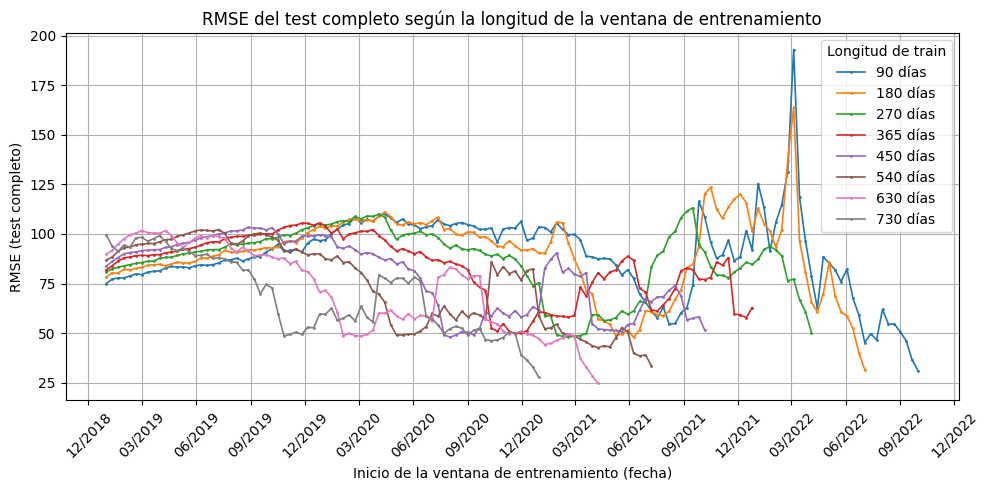

     train_days  train_start_time  rmse_test
137          90            1370.0  31.042965
266         180            1280.0  31.543398
345         270             780.0  47.984159
456         365             690.0  49.742852
555         450             580.0  47.976595
691         540             920.0  33.535458
775         630             830.0  24.569502
849         730             730.0  27.726908


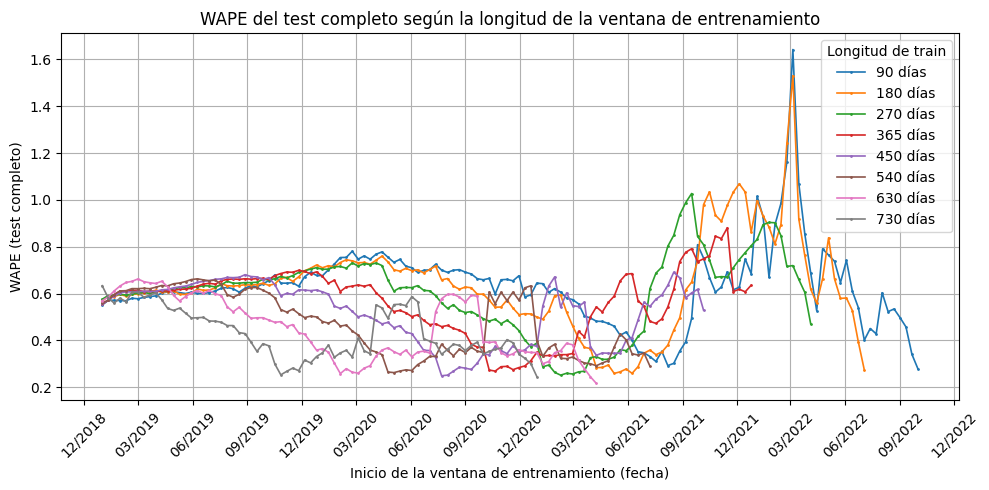

     train_days  train_start_time  wape_test
137          90            1370.0   0.278790
224         180             860.0   0.258695
344         270             770.0   0.251238
453         365             660.0   0.268600
554         450             570.0   0.248759
648         540             490.0   0.262178
775         630             830.0   0.215778
849         730             730.0   0.245480


In [15]:
def time_idx_to_date(time_idx, start_date="2019-01-01"):
    """
    Convierte un índice de tiempo (entero) en una fecha.
    
    Parámetros
    ----------
    time_idx : int o array-like
        Índice(s) de tiempo donde 1 = start_date
    start_date : str o datetime
        Fecha inicial (por defecto 2019-01-01)
    
    Retorna
    -------
    pandas.Timestamp o pandas.DatetimeIndex
    """
    start = pd.to_datetime(start_date)
    return start + pd.to_timedelta(time_idx - 1, unit="D")


results_all["date"] = time_idx_to_date(results_all["train_start_idx"])
# results_all["date"] = results_all["train_start_idx"]

fig, ax = plt.subplots(figsize=(10, 5))

for train_days, g in results_all.groupby("train_days"):
    plt.plot(
        g["date"],
        g["rmse_test"],
        marker="o",
        markersize=1,
        linewidth=1.2,
        label=f"{train_days} días"
    )

ax.set_xlabel("Inicio de la ventana de entrenamiento (fecha)")
ax.set_ylabel("RMSE (test completo)")
ax.set_title("RMSE del test completo según la longitud de la ventana de entrenamiento")

# Resolución trimestral (cada 3 meses)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%Y"))

plt.xticks(rotation=45)
ax.grid(True)
ax.legend(title="Longitud de train")

fig.tight_layout()
plt.show()


min_points_1 = (
    results_all
    .loc[results_all.groupby("train_days")["rmse_test"].idxmin()]
    [["train_days", "train_start_time", "rmse_test"]]
    .sort_values("train_days")
)

print(min_points_1)


fig, ax = plt.subplots(figsize=(10, 5))

for train_days, g in results_all.groupby("train_days"):
    plt.plot(
        g["date"],
        g["wape_test"],
        marker="o",
        markersize=1,
        linewidth=1.2,
        label=f"{train_days} días"
    )

ax.set_xlabel("Inicio de la ventana de entrenamiento (fecha)")
ax.set_ylabel("WAPE (test completo)")
ax.set_title("WAPE del test completo según la longitud de la ventana de entrenamiento")

# Resolución trimestral (cada 3 meses)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%Y"))

plt.xticks(rotation=45)
ax.grid(True)
ax.legend(title="Longitud de train")

fig.tight_layout()
plt.show()

min_points_2 = (
    results_all
    .loc[results_all.groupby("train_days")["wape_test"].idxmin()]
    [["train_days", "train_start_time", "wape_test"]]
    .sort_values("train_days")
)

print(min_points_2)

